# Introduction
learn how to generate graphs given examples. 

Graphlearn has a fit and a sample stage. 
1. Fit: given graphs, train an estimator, collect graph fragments.
2. Sample: given initial graphs, optimize by exchanging random fragments and scoring via the estimator.

The graph fragments are organized in a grammar that groups interchangeable (congruent) subgraphs.
The estimator is either a one or two class estimator. The Sampling process is adjustable, it might ensemble
MCMC sampling, simulated annealing or just straight greedy improvement of graphs.

See the last Notebook of this introduction for more details about the sampling process.

### Ipython Notebook init

In [31]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(), verbosity=1) # use 2 for more info
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style><style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Fitting a sampler


### Graph formats

The sampler expects networkx graphs. Overview on supported graph formats:
https://networkx.github.io/documentation/networkx-1.10/reference/readwrite.html.
The eden package, that is required to run graphlearn, supports additional formats.

We define get_graphs which will return an iterable over networkx graphs.



### Fitting options

##### sampler init:
We see the default options for learning the grammar.
these are not very optimized.

You may provide a feasibility_checker that aproves all 
generated graphs. To exclude single nodes from the grammar, rendering them unchangeable, the node_entity_checker is interesting.

##### fitting:
Here a oneclass estimator will be used.
You might also provide a second set of graphs
or give a pretrained estimator in sampler init.

In [2]:
from eden.io.gspan import gspan_to_eden

from itertools import islice
def get_graphs(dataset_fname, size=100):
    return  list(islice(gspan_to_eden(dataset_fname),size))

dataset_fname = '../toolsdata/bursi.pos.gspan'

In [23]:
from graphlearn.graphlearn import  Sampler
from graphlearn.graphlearn import LocalSubstitutableGraphGrammar
import eden

sampler=Sampler(
            vectorizer=eden.graph.Vectorizer(complexity=3,n_jobs=2),
            random_state=1,
            estimator=estimate.OneClassEstimator(nu=.5, cv=2, n_jobs=-1),
            #graphtransformer=transform.GraphTransformer(),
            #feasibility_checker=feasibility.FeasibilityChecker(),
            #decomposer=decompose.Decomposer(node_entity_check=lambda x, y:True, nbit=20),
            grammar=LocalSubstitutableGraphGrammar(radius_list=[0,1], thickness_list=[1,2], min_cip_count=2,min_interface_count=2),
            n_steps=60, 
            n_samples=4,
            core_choice_byfrequency=False,
            core_choice_byscore= False,
            core_choice_bytrial= True,
            size_diff_core_filter=2,
            burnin=10,
            include_seed=True,
            proposal_probability = False,
            improving_threshold_fraction=.5, 
            improving_linear_start_fraction=0.0,
            accept_static_penalty=0.0,
            n_jobs=1,
            select_cip_max_tries=200,
            keep_duplicates=True,  
            monitor=True)

In [24]:
%%time
decomposers = sampler.fit_make_decomposers(get_graphs(dataset_fname, size=500))
sampler.fit_grammar(decomposers)
sampler.fit_estimator(decomposers)

# lets look at a few stats about the trained sampler
print('graph grammar stats:')
n_instances, interface_counts, core_counts, cip_counts = sampler.grammar().size()
print('#instances: %d   #interfaces: %d   #cores: %d   #core-interface-pairs: %d' % (n_instances, interface_counts, core_counts, cip_counts))

# dumps the sampler for later use. This is not mandatory :) 
sampler.save('../tmp/sampler.ge')

graph grammar stats:
#instances: 500   #interfaces: 331   #cores: 100   #core-interface-pairs: 1256
CPU times: user 21.3 s, sys: 1.49 s, total: 22.8 s
Wall time: 30.1 s


# Grammar Inspection

If you are interested in the generated grammar, there are 
two useful tools available. 
You can draw the grammar directly, as seen below.
draw_grammar_stats will collect statistics about the grammar and visualize them nicely.

interface id: 540114 [34 options]


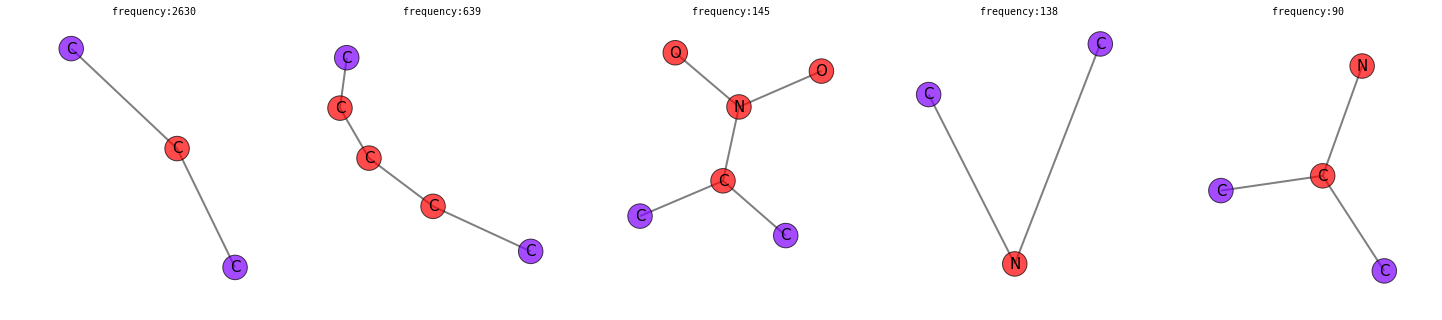

interface id: 406004 [34 options]


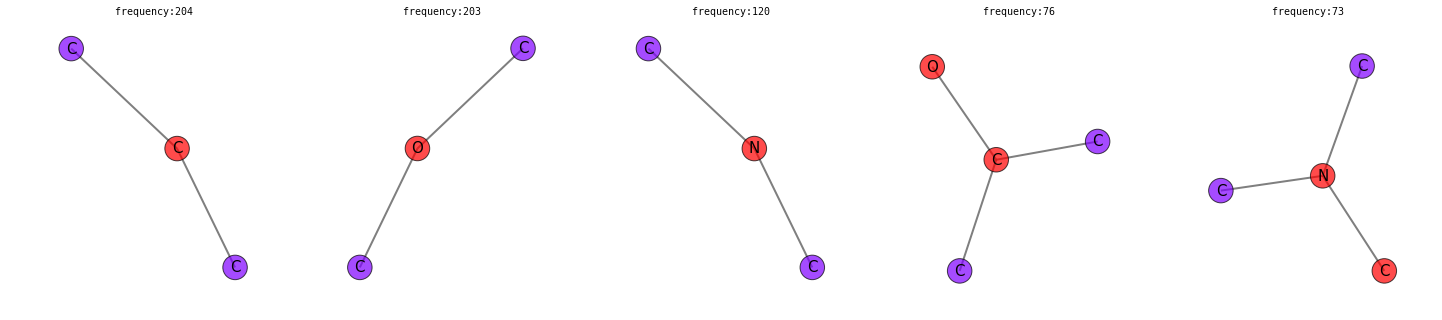

interface id: 790444 [31 options]


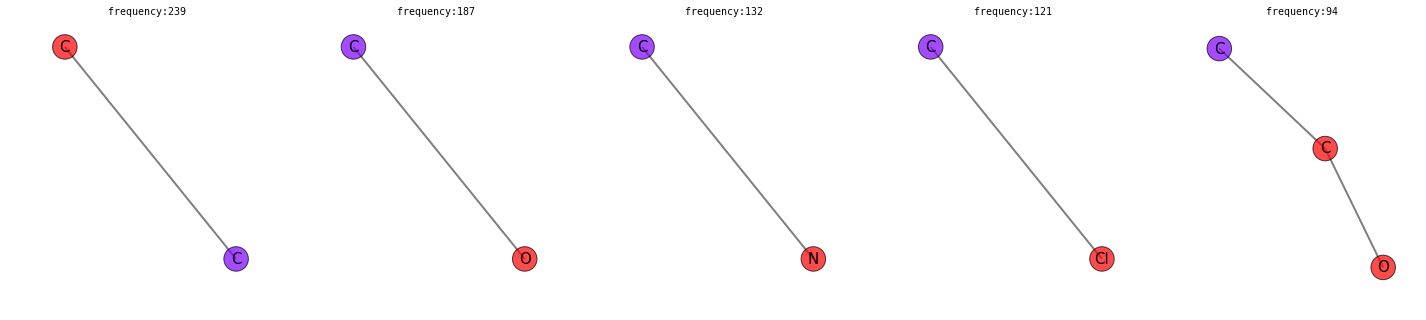

In [25]:
# draw one group of graph fragments (CIPS)

from graphlearn.utils.draw import draw_grammar
draw_grammar(sampler.grammar().productions, contract=True,
             n_productions=3,
             n_graphs_per_line=5,
             n_graphs_per_production=5,
             size=5, 
             colormap='rainbow', 
             vertex_border=1, 
             vertex_alpha=0.7, 
             edge_alpha=0.5)

how often do we see interface hashes
# productions: 1256
x = # interfaces (total: 331)
y=number of cores(ihash), y=sum Of Core Counts(ihash)


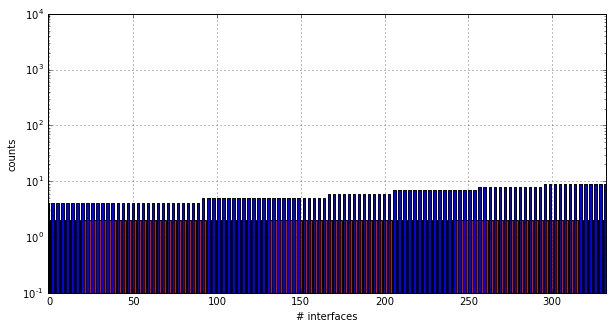

how often was this corehash seen?
x = # cores (total: 100)
y = in Y interfaces(chash), y= sum Of Count Over All Interfaces(chash)


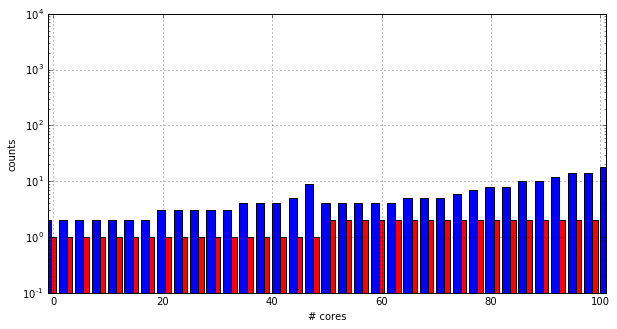

histogram
# productions: 1256
distinct cores: 100 (seen on x axis)
interfaces with x many cores were observed y many times. 


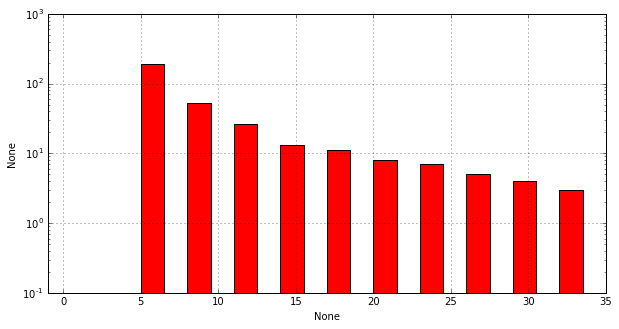

other histogram
how many cores exist with x many interfaces


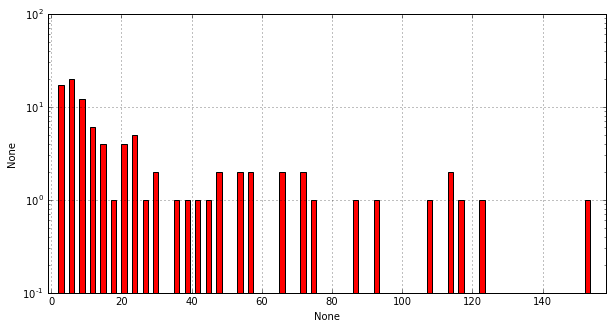

In [26]:
from graphlearn.utils.draw import draw_grammar_stats
draw_grammar_stats(sampler.lsgg.productions, size=(10,5))

# Sample

Sampling with default options will work just fine if you are just interested
in new graphs. The n_steps parameter defines 
how many attempts of altering a graph are made.

##### Options that will influence the acceptance of a generated graph:

In each sampling step, a graph is altered and scored.
An accept function decides if we keep the new graph. The parameters listed here 
influence this acceptance function.

improving_threshold=.5,
after this fraction of steps, only improvements are accepted  ---
improving_linear_start=0.0, 
graphs are accepted with a probability depending on their score. From this fraction it becomes gradually harder for worse graphs to be accepted. ---
accept_static_penalty=0.0, 
graphs that are worse than their predecessors get this penalty (on top of the other two options).

##### Options for choosing the new fragment:

The fragment chosen for alteration can be influenced by the acceptable node parameter (see sampler init). 
In general it will be chosen randomly. The fragment it will be replaced with can be influenced however:

probabilistic_core_choice=False, with this option we choose the fragment according to its frequency in the grammar.  ---
score_core_choice= True, choose the fragment according to score ( given by estimator ), the better the score, the more likely it is for a fragment to be picked ---
max_size_diff=1, maximum size difference between the seed graph and every graph generated graph. if choosing a fragment will violate the 
size constraints, it will not be selected.

#####  Output multiple graphs (along the sample path):


burnin=10, ignore the first burnin graphs for the nsamples parameter ---
n_samples=n_samples, from burnin to end of sample, collect this many samples. ---
keep_duplicates=True, duplicates may be deleted ---
include_seed=True,  seed will be the first graph in the output list. 

##### Collect additional information during sampling, that may help debugging

monitor=True, after sampling acessible via eg sampler.monitors[1][9] (first graph, ninth step)
                        
##### Output format 
sample() will yield a list of graph for each input graph.

In [28]:
from itertools import islice
from graphlearn.graphlearn import  Sampler
#sampler=Sampler()
#sampler.load('../tmp/sampler.ge')

# picking graphs
graphs = get_graphs(dataset_fname, size=100)
id_start=10
id_end=id_start+6
input_graphs = islice(graphs,id_start,id_end)
graphs = sampler.transform(input_graphs)

Graph id: 10


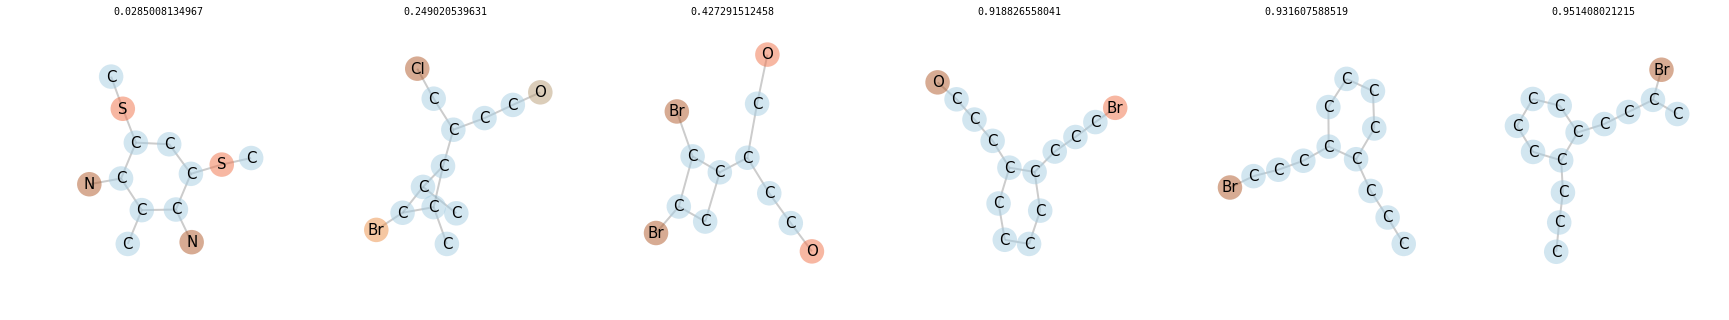

Graph id: 11


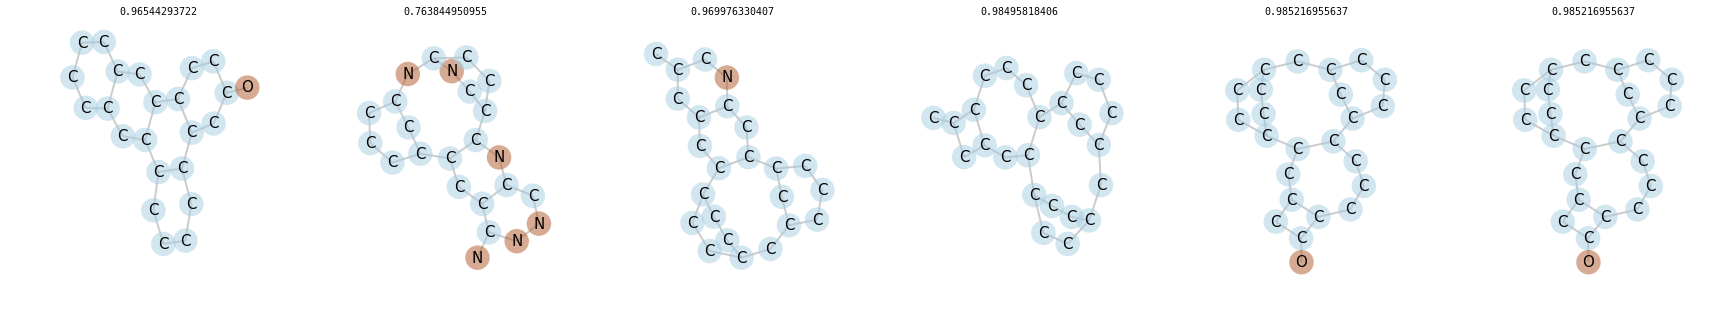

Graph id: 12


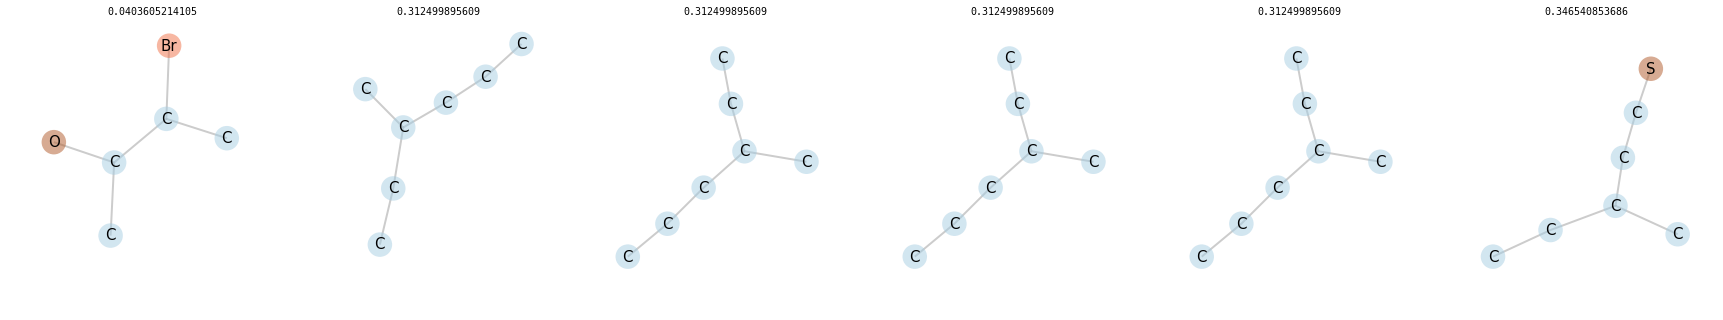

Graph id: 13


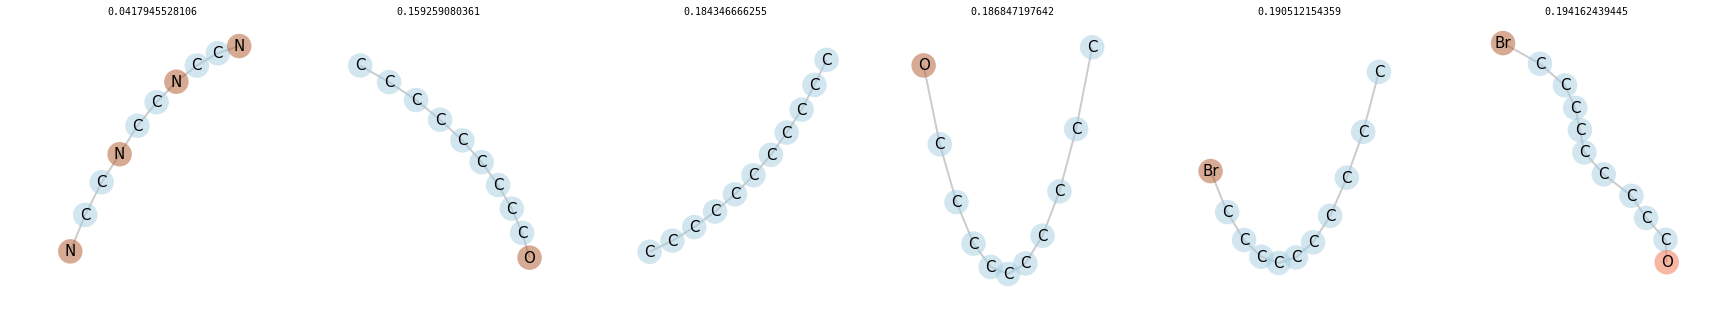

Graph id: 14


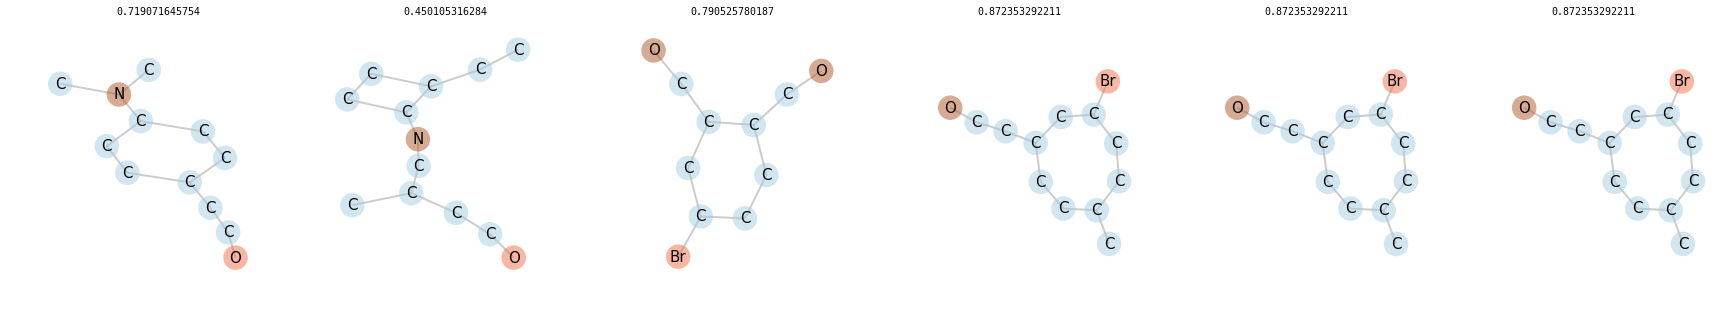

Graph id: 15


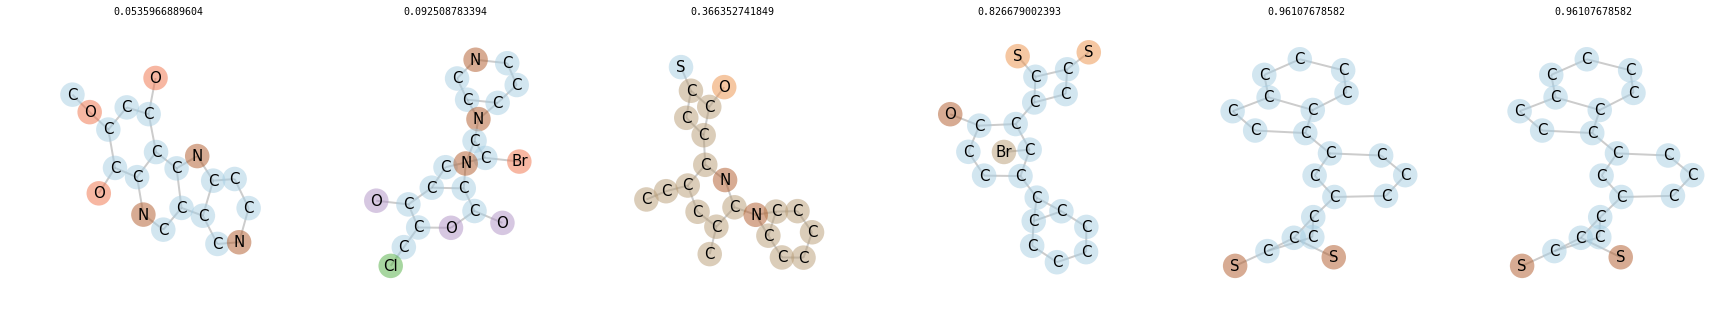

CPU times: user 23.7 s, sys: 1.23 s, total: 24.9 s
Wall time: 45.2 s


In [29]:
%%time
BABELDRAW=False
# for each graphlist that is yielded by the sampler:
scores=[]
ids=range(id_start,id_end)
for i,graphlist in enumerate(graphs):
    
    # collect scores of each graph that appeared during the sampling 
    print 'Graph id: %d'%(ids[i])
    scores.append(sampler.monitors[i].sampling_info['score_history'])
    
    # choose a drawing method.
    if BABELDRAW:
        # babel draw looks nice, but may lack detail
        from graphlearn.utils import molecule as mol
        mol.draw(graphlist, n_graphs_per_line=3,smiles=True)
    else:
        from graphlearn.utils import draw
        # graphlearns drawing method is offering many options
        draw.graphlearn(graphlist,
                        contract=True,
                        n_graphs_per_line=6, 
                        size=5, 
                        colormap='Paired', 
                        invert_colormap=False,
                        #node_border=0.5, 
                        title_key='score',
                        vertex_color='_labels_',
                        vertex_alpha=0.5, 
                        edge_alpha=0.2)

# Show sample score history

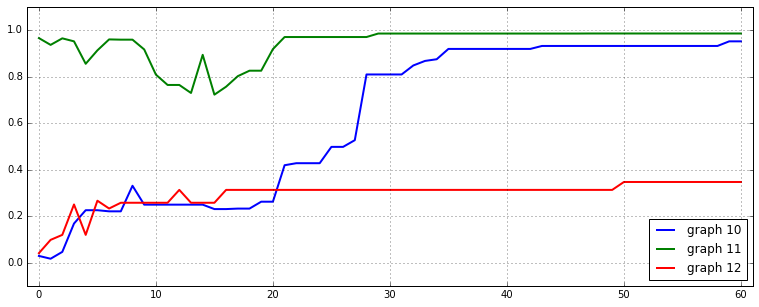

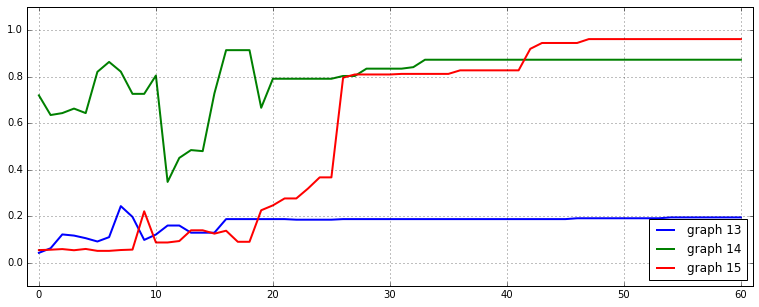

CPU times: user 532 ms, sys: 34.3 ms, total: 566 ms
Wall time: 552 ms


In [30]:
%%time
from itertools import islice
import numpy as np
import pylab as plt

step=1
num_graphs_per_plot=3
num_plots=np.ceil([len(scores)/num_graphs_per_plot])

for i in range(num_plots):
    plt.figure(figsize=(13,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
     
        data = list(islice(score, None, None, step))
        plt.plot(data, linewidth=2, label='graph %d'%(j+i*num_graphs_per_plot+id_start))
        #plt.plot(data, linestyle='None', markerfacecolor='white', marker='o', markeredgewidth=2,markersize=6) # markevery=n_steps/(n_samples),
    plt.legend(loc='lower right')
    plt.grid()
    plt.xlim(-1,n_steps+1)
    plt.ylim(-0.1,1.1)
    plt.show()

---